In [ ]:
# create a virtual environment and install autokeras, matplotlib, pyarrow
# do not install keras or tensorflow one of them creates dependency issues

# Necessary imports
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import pathlib
import pandas as pd
import math

import io
import requests
from PIL import Image

# check on housing data
# prices in logscale
# mirror images 

In [14]:
# Download the csv from github of anais
art = pd.read_csv('cleaned_prices.csv')

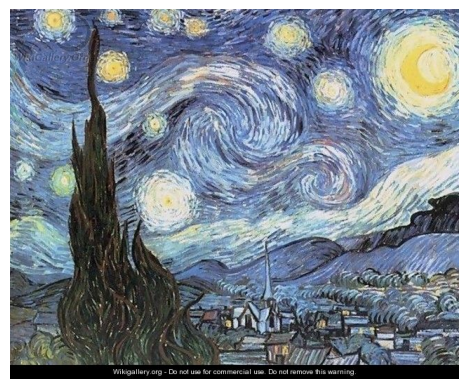

5213


In [20]:
def display_artwork(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
display_artwork(art.image_url.values[0])
print(art.price.size)

In [23]:
# Collect all data

# Convolutional neural network (CNN) needs same shapes as input, so add zero padding untill max size of all images
new_width = 660
new_height = 660

# Resize images to make it computationally less heavy, might be removed in final regressor
img_size = 224

# Number of images loaded to train regressor, note some images will be removed because they do not have ratings
tot_im = 4000


def get_train_data(label, start_id, end_id):
    x_data = [] 
    y_data = []
    url = label.image_url
    for i in range(start_id,end_id):#label.id:
        try:
            response = requests.get(url[i])
            image = Image.open(io.BytesIO(response.content))
            # Padding
            #result = Image.new(image.mode, (new_width, new_height))
            #result.paste(image, (0,0))
            #result = result.resize((img_size, img_size))
            
            # Cropping
            size = min(image.size)  -40     # New dimension
            width, height = image.size   # Get dimensions

            left = (width   - size)/2
            top = (height   - size)/2
            right = (width  + size)/2
            bottom = (height+ size)/2

            # Crop the center of the image
            result = image.crop((left, top, right, bottom))
            result = result.resize((img_size, img_size))
            
            if ((np.asarray(result).shape == (img_size,img_size,3))
                and (not math.isnan(label.price[i]))):
                x_data.append(np.asarray(result))
                y_data.append(label.price[i])
        except Exception as e:
            print(e)
    return (x_data, y_data)

(x_train,y_train) =get_train_data(art, 0, tot_im)
tot_val_im = int(0.2*tot_im)
(x_val, y_val) = get_train_data(art, tot_im, tot_im+tot_val_im)
(x_test, y_test) = get_train_data(art, tot_im+tot_val_im, tot_im+tot_val_im+int(0.1*tot_im))

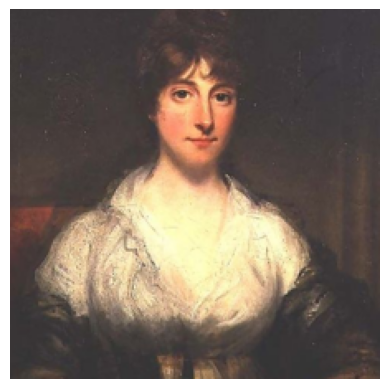

In [24]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
plt.imshow(x_test[1])
plt.axis("off")
plt.show()

In [31]:
data = [x_train, y_train, x_val, y_val, x_test, y_test]
for i in range(len(data)):
    #np.save('datathon_image_price'+str(i)+'.npy', data[i])

In [32]:
## With autokeras does not yet work so ignore
### Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, max_trials=5, metrics = ['mean_absolute_percentage_error'])
### Feed the image regressor with training data.
reg.fit(x_train, y_train, epochs=10)
### Predict with the best model.
predicted_y = reg.predict(x_test)
print(predicted_y)
### Evaluate the best model with testing data.
print(reg.evaluate(x_test, y_test))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |?                 |image_block_1/normalize
False             |?                 |image_block_1/augment
resnet            |?                 |image_block_1/block_type
False             |?                 |image_block_1/res_net_block_1/pretrained
resnet50          |?                 |image_block_1/res_net_block_1/version
False             |?                 |image_block_1/res_net_block_1/imagenet_size
0                 |?                 |regression_head_1/dropout
adam              |?                 |optimizer
0.001             |?                 |learning_rate

Epoch 1/10
100/100 [==============================] - 1059s 11s/step - loss: 9040202563584.0000 - mean_absolute_percentage_error: 271.4834 - val_loss: 3252569505792.0000 - val_mean_absolute_percentage_error: 252.9211
Epoch 2/10
100/100 [==============================] - 989s 10s/step - loss: 9020625649664.0000 - mean_absolute_perce

KeyboardInterrupt: 

In [ ]:
model = reg.export_model()

In [ ]:
model.summary()
model.save('model_reg_autokeras_pricesclean_4000im_mape-'+ str(history.history['mean_absolute_percentage_error'][-1])'.h5')

In [13]:
part_x_test = x_test[:]
y_test_pred = reg.predict(part_x_test)
for i in range(len(y_test[:])):
    print((y_test[i]-y_test_pred[i][0])/y_test[i], y_test[i], y_test_pred[i])

1/1 [==============================] - 1s 1s/step
-2107.2608234295417 589.0 [1241765.6]
-0.6824109375 600000.0 [1009446.56]
0.6466714051079832 3356589.0 [1185978.9]
0.712818992675575 4363619.0 [1253148.5]
0.4290974488384956 1808000.0 [1032191.8]
-2.7710763120852606 338164.0 [1275242.2]
0.4693312361725664 1808000.0 [959449.1]
0.8434704472308049 3356589.0 [525405.4]
0.4371338372093023 2150000.0 [1210162.2]
-0.746389 1000000.0 [1746389.]
0.43641755392699116 1808000.0 [1018957.06]
-182.2866600790514 7590.0 [1391145.8]
0.7013629496582311 5392679.0 [1610453.8]
0.41950753595132745 1808000.0 [1049530.4]
0.32501949668141594 1808000.0 [1220364.8]
0.2730032142857143 1750000.0 [1272244.4]
0.31709383720930234 2150000.0 [1468248.2]
-1.5941555172413793 362500.0 [940381.4]
-15677.464583333332 120.0 [1881415.8]
-3.953166896551724 362500.0 [1795523.]
-1.5892405172413793 362500.0 [938599.7]
-29.60781 50000.0 [1530390.5]
-718.1539090909091 2750.0 [1977673.2]
-1.4136333962264152 662500.0 [1599032.1]


In [ ]:
Epoch 20/20
30/30 [==============================] - 558s 19s/step - loss: 65.0527 - mean_squared_error: 65.0527
[10. 10.  8. 10.  6.  5.  9. 10.  8.  9.  7.  7. 10.  5.  1.  6.  8.  7.
 10. 10. 10.  7.  9. 10.  9. 10.  5. 10.  8. 10. 10.  7.  8.  9. 10.  9.
 10.  6. 10.  8.  7. 10. 10. 10.  6.  9.  6.  9.  9.  9.  8. 10.  8.  8.
  9. 10. 10. 10.  3.  8. 10. 10. 10.  6.  8. 10.  8.  9.  7. 10.  3. 10.
 10.  6. 10.  1.  9. 10. 10. 10. 10. 10. 10. 10.  9.  9.  8. 10.  6. 10.
 10. 10. 10. 10. 10. 10.  8. 10.  9.  8. 10.  1.  8.  5. 10. 10.] [[11.317704 ]
 [11.17027  ]
 [11.717453 ]
 [10.773221 ]
 [10.97231  ]
 [ 9.042419 ]
 [12.937242 ]
 [10.960206 ]
 [11.030711 ]
 [13.353089 ]
 [11.131926 ]
 [36.486374 ]
 [54.452915 ]
 [38.692795 ]
 [11.105588 ]
 [11.902945 ]
 [20.329412 ]
 [11.090957 ]
 [11.137999 ]
 [25.052404 ]
 [11.177988 ]
 [11.0562315]
 [10.96181  ]
 [11.129635 ]
 [11.200332 ]
 [11.17078  ]
 [10.881464 ]
 [11.0289755]
 [11.08791  ]
 [11.005615 ]
 [10.986158 ]
 [11.045911 ]
 [10.892127 ]
 [11.083813 ]
 [ 9.859759 ]
 [11.095887 ]
 [11.082517 ]
 [11.2569895]
 [10.917445 ]
 [11.056289 ]
 [10.833142 ]
 [ 5.2773695]
 [11.03523  ]
 [11.436821 ]
 [11.203466 ]
 [10.894445 ]
 [11.193949 ]
 [11.217446 ]
 [10.959052 ]
 [10.755098 ]
 [11.245361 ]
 [10.97241  ]
 [10.994813 ]
 [11.166839 ]
 [11.098891 ]
 [40.44775  ]
 [11.013785 ]
 [11.346658 ]
 [ 6.6634927]
 [11.09338  ]
 [11.126182 ]
 [15.139627 ]
 [10.833788 ]
 [12.165911 ]
 [11.065518 ]
 [11.165853 ]
 [10.831566 ]
 [11.333715 ]
 [11.107806 ]
 [11.086474 ]
 [11.78077  ]
 [10.870473 ]
 [10.943145 ]
 [11.289582 ]
 [10.9851265]
 [10.821589 ]
 [11.619005 ]
 [10.964395 ]
 [11.105444 ]
 [11.019744 ]
 [48.10924  ]
 [15.000882 ]
 [11.174676 ]
 [17.796457 ]
 [25.064142 ]
 [10.80319  ]
 [46.19295  ]
 [11.48095  ]
 [44.706936 ]
 [66.09218  ]
 [11.503761 ]
 [11.1353   ]
 [11.030078 ]
 [10.988797 ]
 [11.107711 ]
 [10.82532  ]
 [10.85588  ]
 [10.981291 ]
 [11.01253  ]
 [11.163119 ]
 [11.070073 ]
 [11.486185 ]
 [11.015672 ]
 [11.332606 ]
 [10.246537 ]
 [10.908054 ]]
